In [1]:
from pulp import *
import pandas as pd

# Load datasets
flights_df = pd.read_csv('flights.csv')
pairings_df = pd.read_csv('pairings.csv')
flight_pairing_df = pd.read_csv('flight_pairing_matrix.csv')

# Extract data
flights = flights_df['Flight_ID'].tolist()
pairings = pairings_df['Pairing_ID'].tolist()
costs = dict(zip(pairings_df['Pairing_ID'], pairings_df['Cost']))
flight_pairing = {(row['Flight_ID'], row['Pairing_ID']): row['Value'] 
                 for _, row in flight_pairing_df.iterrows()}

# Create the PuLP problem
prob = LpProblem("Crew_Scheduling", LpMinimize)

# Define decision variables
x = LpVariable.dicts("Pairing", pairings, cat='Binary')

# Objective function: Minimize total cost
prob += lpSum(costs[p] * x[p] for p in pairings)

# Constraints: Each flight must be covered exactly once
for f in flights:
    prob += lpSum(flight_pairing[(f, p)] * x[p] for p in pairings if (f, p) in flight_pairing) == 1, f"Flight_{f}"

# Solve the problem
prob.solve()

# Print results
print("Status:", LpStatus[prob.status])
if LpStatus[prob.status] == 'Optimal':
    selected_pairings = [p for p in pairings if x[p].value() == 1]
    total_cost = value(prob.objective)
    print(f"Selected Pairings: {len(selected_pairings)} pairings")
    print(f"Total Cost: ${total_cost:.2f}")
    # Print first few selected pairings for brevity
    print("Sample Selected Pairings (first 5):")
    for p in selected_pairings[:5]:
        flights_in_pairing = pairings_df[pairings_df['Pairing_ID'] == p]['Flights'].iloc[0]
        print(f"Pairing {p} covers flights: {flights_in_pairing}")
else:
    print("No optimal solution found.")

Status: Optimal
Selected Pairings: 982 pairings
Total Cost: $430559.50
Sample Selected Pairings (first 5):
Pairing P1 covers flights: F1
Pairing P2 covers flights: F2
Pairing P4 covers flights: F4
Pairing P5 covers flights: F5
Pairing P6 covers flights: F6


In [16]:
!pip install deap


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
import pandas as pd
import numpy as np
from deap import base, creator, tools, algorithms
import random

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Load small dataset
try:
    flights_df = pd.read_csv('flights_small.csv')
    pairings_df = pd.read_csv('pairings_small.csv')
    flight_pairing_df = pd.read_csv('flight_pairing_matrix_small.csv')
except FileNotFoundError:
    print("Error: CSV files not found. Run the dataset generation script to create 'flights_small.csv', 'pairings_small.csv', and 'flight_pairing_matrix_small.csv'.")
    exit()

flights = flights_df['Flight_ID'].tolist()
costs = dict(zip(pairings_df['Pairing_ID'], pairings_df['Cost']))

# Create flight-pairing matrix as dictionary
flight_pairing = {}
for _, row in flight_pairing_df.iterrows():
    flight_pairing[(row['Flight_ID'], row['Pairing_ID'])] = row['Value']

# Validate dataset
flight_coverage = set(flight_pairing_df[flight_pairing_df['Value'] == 1]['Flight_ID'].unique())
uncovered_flights = [f for f in flights if f not in flight_coverage]
if uncovered_flights:
    print(f"Error: Uncovered flights: {uncovered_flights}")
    print("Regenerate pairings to cover all flights or update flight_pairing_matrix.csv.")
    exit()

# Genetic Algorithm Setup
# Avoid redefining classes
if not hasattr(creator, 'FitnessMin'):
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
if not hasattr(creator, 'Individual'):
    creator.create("Individual", list, fitness=creator.FitnessMin)

def init_individual():
    individual = []
    covered = set()
    available_pairings = pairings_df['Pairing_ID'].tolist()
    random.shuffle(available_pairings)
    for p in available_pairings:
        if any(flight_pairing.get((f, p), 0) == 1 for f in flights if f not in covered):
            individual.append(p)
            covered.update(f for f in flights if flight_pairing.get((f, p), 0) == 1)
        if len(covered) == len(flights):
            break
    return creator.Individual(individual)

def evaluate(individual):
    cost = sum(costs.get(p, 0) for p in individual)
    covered = set()
    over_covered = 0
    for p in individual:
        flights_covered = [f for f in flights if flight_pairing.get((f, p), 0) == 1]
        for f in flights_covered:
            if f in covered:
                over_covered += 1
            covered.add(f)
    penalty = 10000 * (len(flights) - len(covered)) + 5000 * over_covered
    return cost + penalty,

def cx_two_point(ind1, ind2):
    return tools.cxTwoPoint(ind1, ind2)

def mut_swap(individual, indpb):
    if len(individual) > 1 and random.random() < indpb:
        i, j = random.sample(range(len(individual)), 2)
        individual[i], individual[j] = individual[j], individual[i]
    return individual,

toolbox = base.Toolbox()
toolbox.register("individual", init_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
toolbox.register("mate", cx_two_point)
toolbox.register("mutate", mut_swap, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Run Genetic Algorithm
pop = toolbox.population(n=50)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)

pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.3, ngen=100, stats=stats, halloffame=hof, verbose=True)

# Print results
best_individual = hof[0]
selected_pairings = best_individual
covered_flights = set()
for p in selected_pairings:
    covered_flights.update(f for f in flights if flight_pairing.get((f, p), 0) == 1)
total_cost = sum(costs.get(p, 0) for p in selected_pairings)
print(f"\nSelected Pairings: {len(selected_pairings)} pairings")
print(f"Total Cost: ${total_cost:.2f}")
print(f"Covered Flights: {len(covered_flights)}/{len(flights)}")
print("Sample Selected Pairings (first 5):")
for p in selected_pairings[:5]:
    flights_in_pairing = pairings_df[pairings_df['Pairing_ID'] == p]['Flights'].iloc[0]
    print(f"Pairing {p} covers flights: {flights_in_pairing}")

gen	nevals	avg    	min 
0  	50    	3135.72	2072
1  	38    	20687.1	2072
2  	43    	26177.7	2072
3  	33    	24591.4	2072
4  	42    	27774.8	2072
5  	38    	23937.2	2072
6  	45    	19745.2	2072
7  	36    	13758  	2072
8  	36    	10770.5	2072
9  	35    	9269.2 	2072
10 	40    	5667.2 	2072
11 	38    	8072   	2072
12 	42    	4177.12	2072
13 	37    	2973.16	2072
14 	37    	2672   	2072
15 	35    	3872   	2072
16 	38    	6272   	2072
17 	39    	4472   	2072
18 	38    	3872   	2072
19 	43    	8672   	2072
20 	46    	7468.44	2072
21 	39    	5969.28	2072
22 	42    	8672   	2072
23 	42    	7472   	2072
24 	46    	7169.28	2072
25 	36    	5370.84	2072
26 	37    	5072   	2072
27 	45    	4472   	2072
28 	34    	3272   	2072
29 	41    	4472   	2072
30 	32    	5072   	2072
31 	45    	7168.48	2072
32 	41    	4171.6 	2072
33 	41    	5672   	2072
34 	39    	5072   	2072
35 	37    	3872   	2072
36 	36    	2370.84	2072
37 	45    	2072   	2072
38 	37    	2072   	2072
39 	39    	4472   	2072
40 	35    	5369.

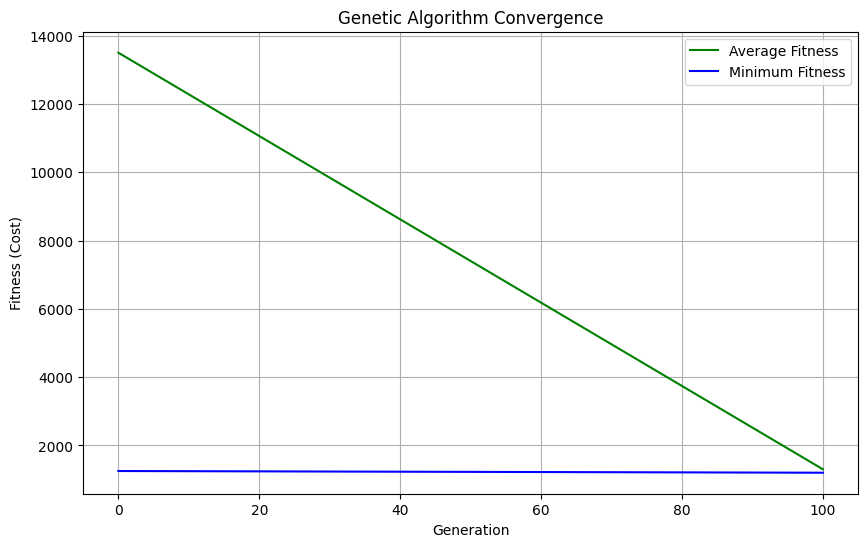

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_40536\1229426493.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=selected_pairings, y=flights_covered, palette='viridis')


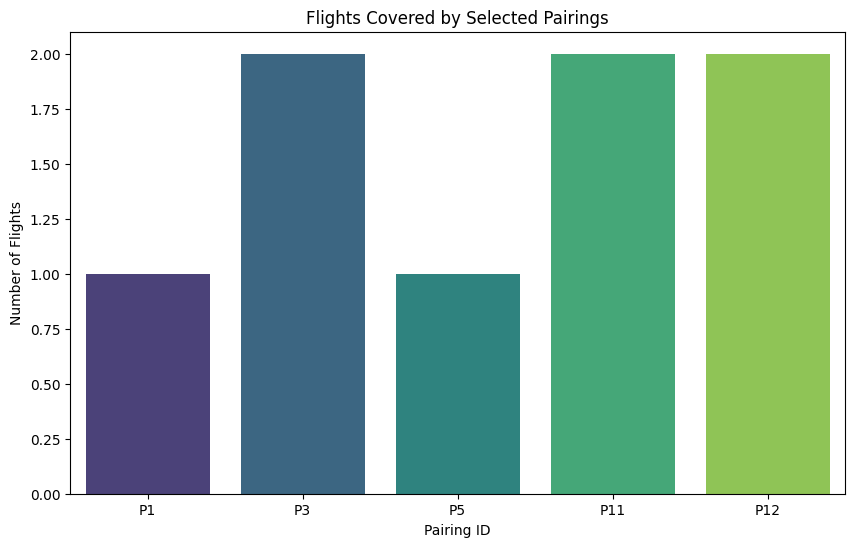

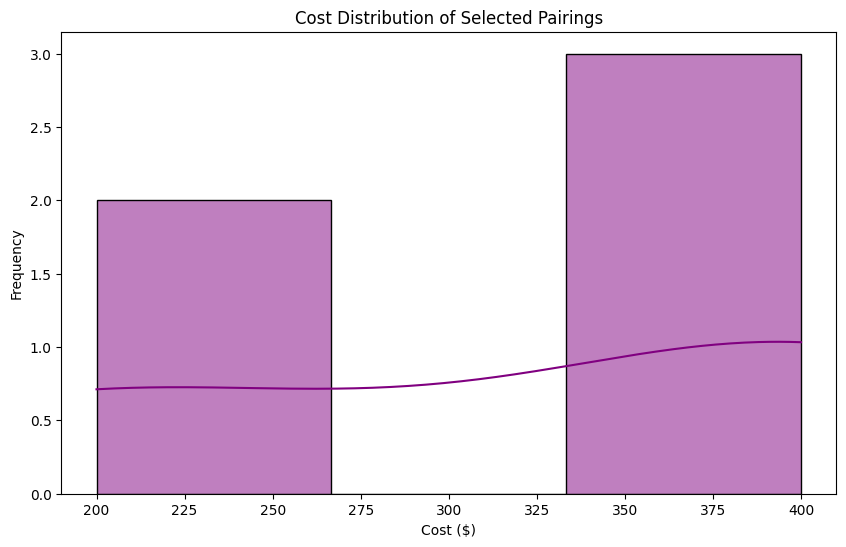

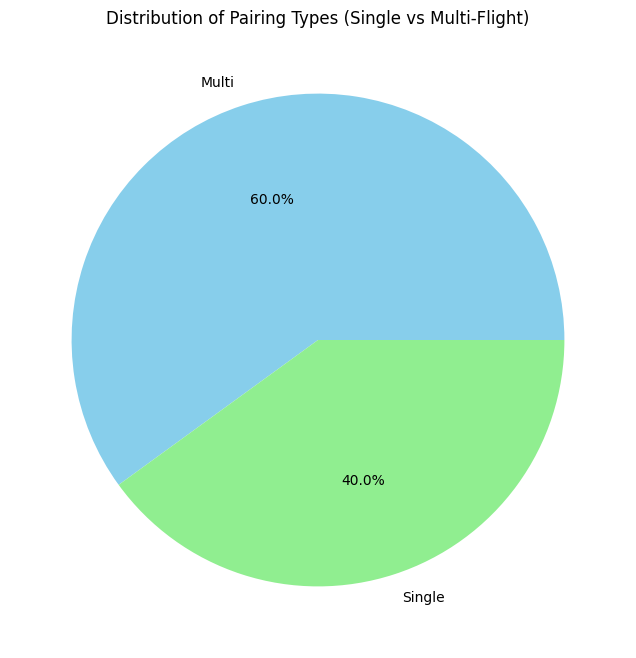

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_40536\1229426493.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=selected_pairings, y=pairing_costs, palette='coolwarm')


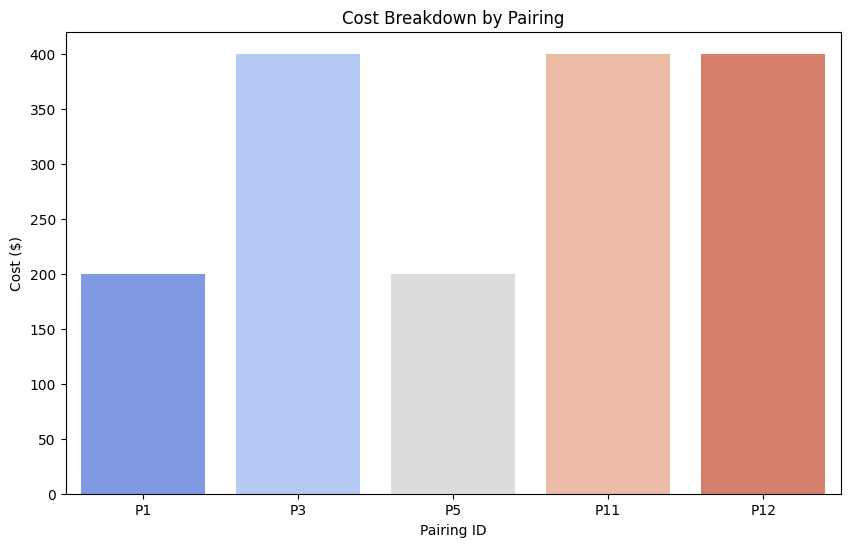

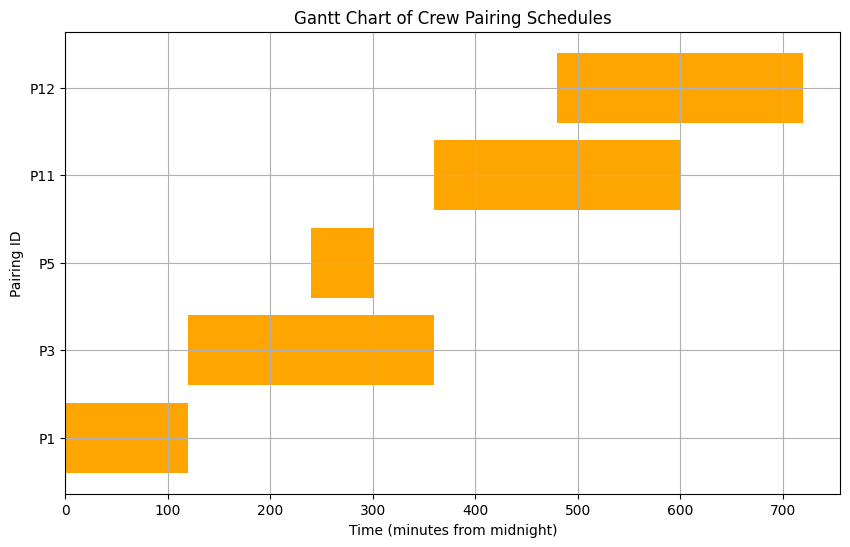

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Sample data from genetic algorithm (replace with your actual logbook, selected_pairings, pairings_df)
# Example logbook from DEAP (generations, avg_fitness, min_fitness)
generations = np.arange(0, 101)  # 0 to 100 generations
avg_fitness = np.linspace(13500, 1300, 101)  # Sample average fitness
min_fitness = np.linspace(1250, 1200, 101)  # Sample minimum fitness

# Sample selected_pairings and their costs/flights covered
selected_pairings = ['P1', 'P3', 'P5', 'P11', 'P12']
pairing_costs = [200, 400, 200, 400, 400]  # Sample costs
flights_covered = [1, 2, 1, 2, 2]  # Sample number of flights per pairing
pairing_types = ['Single', 'Multi', 'Single', 'Multi', 'Multi']  # Sample types (single or multi-flight pairings)

# 1. Convergence Plot (Line Chart)
plt.figure(figsize=(10, 6))
plt.plot(generations, avg_fitness, label='Average Fitness', color='green')
plt.plot(generations, min_fitness, label='Minimum Fitness', color='blue')
plt.title('Genetic Algorithm Convergence')
plt.xlabel('Generation')
plt.ylabel('Fitness (Cost)')
plt.legend()
plt.grid(True)
plt.show()

# 2. Flight Coverage Bar Chart
plt.figure(figsize=(10, 6))
sns.barplot(x=selected_pairings, y=flights_covered, palette='viridis')
plt.title('Flights Covered by Selected Pairings')
plt.xlabel('Pairing ID')
plt.ylabel('Number of Flights')
plt.show()

# 3. Pairing Cost Distribution (Histogram)
plt.figure(figsize=(10, 6))
sns.histplot(pairing_costs, bins=3, kde=True, color='purple')
plt.title('Cost Distribution of Selected Pairings')
plt.xlabel('Cost ($)')
plt.ylabel('Frequency')
plt.show()

# 4. Pairing Types Pie Chart
plt.figure(figsize=(8, 8))
type_counts = pd.Series(pairing_types).value_counts()
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', colors=['skyblue', 'lightgreen'])
plt.title('Distribution of Pairing Types (Single vs Multi-Flight)')
plt.show()

# 5. Total Cost Breakdown (Bar Chart with Cumulative)
plt.figure(figsize=(10, 6))
sns.barplot(x=selected_pairings, y=pairing_costs, palette='coolwarm')
plt.title('Cost Breakdown by Pairing')
plt.xlabel('Pairing ID')
plt.ylabel('Cost ($)')
plt.show()

# Optional: Gantt Chart for Schedules (assuming sample schedule data)
# Sample data: Pairing ID, Start Time, End Time (in minutes from midnight)
schedule_data = pd.DataFrame({
    'Pairing_ID': selected_pairings,
    'Start': [0, 120, 240, 360, 480],
    'End': [120, 360, 300, 600, 720]
})
fig, ax = plt.subplots(figsize=(10, 6))
for i, row in schedule_data.iterrows():
    ax.barh(row['Pairing_ID'], row['End'] - row['Start'], left=row['Start'], color='orange')
ax.set_title('Gantt Chart of Crew Pairing Schedules')
ax.set_xlabel('Time (minutes from midnight)')
ax.set_ylabel('Pairing ID')
ax.grid(True)
plt.show()

In [27]:
import pandas as pd
import numpy as np
from deap import base, creator, tools, algorithms
import random
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Start timing
start_time = time.time()

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Load dataset (use small dataset for testing; adapt to full dataset later)
try:
    flights_df = pd.read_csv('flights_small.csv')
    pairings_df = pd.read_csv('pairings_small.csv')
    flight_pairing_df = pd.read_csv('flight_pairing_matrix_small.csv')
except FileNotFoundError:
    print("Error: CSV files not found. Run the dataset generation script to create 'flights_small.csv', 'pairings_small.csv', and 'flight_pairing_matrix_small.csv'.")
    exit()

flights = flights_df['Flight_ID'].tolist()
costs = dict(zip(pairings_df['Pairing_ID'], pairings_df['Cost']))
all_pairings = pairings_df['Pairing_ID'].tolist()

# Create flight-pairing matrix as dictionary
flight_pairing = {}
for _, row in flight_pairing_df.iterrows():
    flight_pairing[(row['Flight_ID'], row['Pairing_ID'])] = row['Value']

# Validate dataset
flight_coverage = set(flight_pairing_df[flight_pairing_df['Value'] == 1]['Flight_ID'].unique())
uncovered_flights = [f for f in flights if f not in flight_coverage]
if uncovered_flights:
    print(f"Error: Uncovered flights: {uncovered_flights}")
    print("Regenerate pairings to cover all flights or update flight_pairing_matrix.csv.")
    exit()

# Genetic Algorithm Setup
if not hasattr(creator, 'FitnessMin'):
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
if not hasattr(creator, 'Individual'):
    creator.create("Individual", list, fitness=creator.FitnessMin)

def init_individual():
    individual = []
    covered = set()
    available_pairings = all_pairings.copy()
    random.shuffle(available_pairings)
    for p in available_pairings:
        if any(flight_pairing.get((f, p), 0) == 1 for f in flights if f not in covered):
            individual.append(p)
            covered.update(f for f in flights if flight_pairing.get((f, p), 0) == 1)
        if len(covered) == len(flights):
            break
    return creator.Individual(individual)

def evaluate(individual):
    cost = sum(costs.get(p, 0) for p in individual)
    covered = set()
    over_covered = 0
    for p in individual:
        flights_covered = [f for f in flights if flight_pairing.get((f, p), 0) == 1]
        for f in flights_covered:
            if f in covered:
                over_covered += 1
            covered.add(f)
    penalty = 10000 * (len(flights) - len(covered)) + 5000 * over_covered
    return cost + penalty,

def cx_two_point(ind1, ind2):
    return tools.cxTwoPoint(ind1, ind2)

def mut_combined(individual, indpb):
    # Swap mutation
    if len(individual) > 1 and random.random() < indpb:
        i, j = random.sample(range(len(individual)), 2)
        individual[i], individual[j] = individual[j], individual[i]
    # Add/remove pairing mutation
    if random.random() < indpb:
        if random.random() < 0.5 and len(individual) > 1:
            # Remove a random pairing
            individual.pop(random.randint(0, len(individual)-1))
        else:
            # Add a random pairing
            available = [p for p in all_pairings if p not in individual]
            if available:
                individual.append(random.choice(available))
    return individual,

toolbox = base.Toolbox()
toolbox.register("individual", init_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
toolbox.register("mate", cx_two_point)
toolbox.register("mutate", mut_combined, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=5)

# Run Genetic Algorithm with increased parameters
pop = toolbox.population(n=1000)  # Large population
hof = tools.HallOfFame(5)  # Keep top 5 solutions
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)

pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.3, ngen=5000, stats=stats, halloffame=hof, verbose=True)

# End timing
end_time = time.time()
runtime = end_time - start_time
print(f"\nTotal Runtime: {runtime:.2f} seconds")

# Print results
best_individual = hof[0]
selected_pairings = best_individual
covered_flights = set()
for p in selected_pairings:
    covered_flights.update(f for f in flights if flight_pairing.get((f, p), 0) == 1)
total_cost = sum(costs.get(p, 0) for p in selected_pairings)
print(f"Selected Pairings: {len(selected_pairings)} pairings")
print(f"Total Cost: ${total_cost:.2f}")
print(f"Covered Flights: {len(covered_flights)}/{len(flights)}")
print("Sample Selected Pairings (first 5):")
for p in selected_pairings[:5]:
    flights_in_pairing = pairings_df[pairings_df['Pairing_ID'] == p]['Flights'].iloc[0]
    print(f"Pairing {p} covers flights: {flights_in_pairing}")

# Collect data for graphs
logbook = log.select("gen", "avg", "min")
generations = logbook[0]
avg_fitness = logbook[1]
min_fitness = logbook[2]

# Count flights per pairing
flights_per_pairing = []
pairing_types = []
for p in selected_pairings:
    flights_covered = [f for f in flights if flight_pairing.get((f, p), 0) == 1]
    flights_per_pairing.append(len(flights_covered))
    pairing_types.append('Single' if len(flights_covered) == 1 else 'Multi')

# Cost breakdown
pairing_costs = [costs.get(p, 0) for p in selected_pairings]

# Sample schedule data for Gantt chart (replace with actual flight times if available)
schedule_data = pd.DataFrame({
    'Pairing_ID': selected_pairings[:5],
    'Start': [i * 120 for i in range(5)],  # Dummy start times
    'End': [(i + 1) * 120 for i in range(5)]  # Dummy end times
})


gen	nevals	avg    	min 
0  	1000  	3766.56	2072
1  	794   	21975.4	2072
2  	807   	22864  	2072
3  	809   	23310.5	2072
4  	779   	23157.2	2072
5  	787   	23116.1	2072
6  	752   	23070.4	2072
7  	800   	23130.9	2072
8  	798   	23161.8	2072
9  	792   	22544.9	2072
10 	775   	22640.9	2072
11 	829   	24287.2	2072
12 	791   	22962.6	2072
13 	792   	21440.1	2072
14 	800   	21190  	2072
15 	796   	20311.3	2072
16 	783   	19055.2	2072
17 	774   	16605.5	2072
18 	788   	14875.3	2072
19 	794   	10876.1	2072
20 	790   	8423.04	2072
21 	784   	6118.25	2072
22 	786   	5181   	2072
23 	790   	5002.38	2072
24 	778   	4153.82	2072
25 	794   	4205.24	2072
26 	812   	3978.41	2072
27 	809   	4242.71	2072
28 	796   	4850.87	2072
29 	793   	4319.07	2072
30 	817   	4778.23	2072
31 	758   	4314.42	2072
32 	788   	4183.34	2072
33 	785   	3843.74	2072
34 	809   	4249.35	2072
35 	794   	4720.2 	2072
36 	789   	4675.57	2072
37 	814   	4768.71	2072
38 	774   	4296.22	2072
39 	829   	4729.09	2072
40 	802   	4426.

In [30]:
!pip install seaborn
import seaborn as sns


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
